## **code created by Murat Khidoyatov at Yale University**

In [132]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# **Define a function for the variable coefficients, which can depend on x, y, and their derivatives**

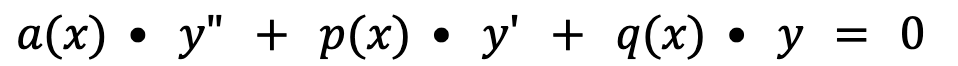

In [133]:
def a_x(x, y, dy_dx): 
    return x**2  # This can be changed to any function of x, y, or dy_dx. Change as needed 

**Always use torch for the math functions instead of the numpy**

In [134]:
def p_x(x, y, dy_dx):
    return x  # Example: Can be x, y, or some nonlinear function. Change as needed 

*or you can just pass down **return np.sin(y)** if your coefficient for y' is sin(y)*

In [135]:
def q_x(x, y, dy_dx):
    return -x  # Example: Can be x, y, or some nonlinear function.  Change as needed 

# **Apply Boundary Conditions**

In [136]:
x_range = (0.1, 10)  # Range for x
initial_conditions = [
    {'type': 'y', 'value': 2.0, 'x': 1.0},    # y(0) = 0
    {'type': 'y\'', 'value': 0.0, 'x': 1.0},  # y'(0) = 1
    #{'type': 'y', 'value': 0.0, 'x': 2 * np.pi},  # y(2*pi) = 0
    # Additional initial conditions can be added if needed
    # {'type': 'y', 'value': ..., 'x': ...},
    # {'type': 'y\'', 'value': ..., 'x': ...}
]


# **Learning rate and number of epochs**

In [137]:
learning_rate = 0.001 
num_epochs = 1000 

# **Define the neural network structure**

In [138]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.hidden_layer_1 = nn.Linear(1, 200)
        self.hidden_layer_2 = nn.Linear(200, 200)
        self.hidden_layer_3 = nn.Linear(200, 200)
        self.output_layer = nn.Linear(200, 1)

    def forward(self, x):
        x = torch.LeakyReLU(self.hidden_layer_1(x))
        x = torch.LeakyReLU(self.hidden_layer_2(x))
        x = torch.LeakyReLU(self.hidden_layer_3(x))
        x = self.output_layer(x)
        return x

# **Define the ODE residual function to train NN model**

In [139]:
def f_ode(x, net):
    y = net(x)  # Neural network approximation of y(x)
    dy_dx = torch.autograd.grad(y, x, torch.ones_like(x), create_graph=True)[0]  # dy/dx
    d2y_dx2 = torch.autograd.grad(dy_dx, x, torch.ones_like(x), create_graph=True)[0]  # d2y/dx2

    # Variable coefficients (these can depend on x, y, dy/dx)
    coeff_n_val = a_x(x, y, dy_dx)
    coeff_1_val = p_x(x, y, dy_dx)
    coeff_0_val = q_x(x, y, dy_dx)

    # General form: coeff_n * y'' + coeff_1 * y' + coeff_0 * y = 0
    ode_residual = coeff_n_val * d2y_dx2 + coeff_1_val * dy_dx + coeff_0_val * y
    
    return ode_residual

# **Apply boundary conditions to train NN model**

# **Apply boundary conditions to train NN model**

In [140]:
# Function to apply initial value conditions (IVP) for both y(x0), y(x1), and y'(x0) if needed
def apply_initial_conditions(net, initial_conditions):
    ivp_residuals = []
    
    for ivp in initial_conditions:
        x_ivp = torch.tensor([[ivp['x']]], requires_grad=True)  # Boundary point at x = ivp['x']
        y_ivp = net(x_ivp)  # Predict y(x_ivp)

        if ivp['type'] == 'y':  # Apply condition for y(x)
            ivp_residual = y_ivp - ivp['value']  # y(x) = given value
        elif ivp['type'] == 'y\'':  # Apply condition for y'(x)
            dy_dx_ivp = torch.autograd.grad(y_ivp, x_ivp, torch.ones_like(x_ivp), create_graph=True)[0]  # y'(x)
            ivp_residual = dy_dx_ivp - ivp['value']  # y'(x) = given value
        
        ivp_residuals.append(ivp_residual)
    
    return torch.sum(torch.stack([ivp**2 for ivp in ivp_residuals]))  # Sum of residuals squared

# **Training the network**

In [141]:
def train(net, optimizer, x_range, initial_conditions, num_epochs):
    x_min, x_max = x_range
    for epoch in range(num_epochs):
        optimizer.zero_grad()  # Reset gradients

        # Sample points in the domain x
        x = torch.linspace(x_min, x_max, 100).view(-1, 1)
        x.requires_grad = True  # Enable gradient tracking for these inputs

        # Compute the ODE residual
        ode_residual = f_ode(x, net)

        # Compute the initial value condition residuals
        ivp_residual = apply_initial_conditions(net, initial_conditions)

        # Define the loss as the sum of the ODE residuals and initial condition residuals
        loss = torch.mean(ode_residual**2) + ivp_residual

        # Perform backpropagation and optimization step
        loss.backward()
        optimizer.step()

        # Print the loss every 10 epochs
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    # Calculate and display the final accuracy and loss after training
    final_loss = loss.item()
    accuracy = calculate_accuracy(net, initial_conditions)
    print(f'\nFinal Loss: {final_loss}')
    print(f'Accuracy in % : {accuracy}')


> **function to calculate accuracy based on boundary conditions**

In [142]:
def calculate_accuracy(net, initial_conditions):
    total_error = 0.0
    max_bc_value = max([abs(ic['value']) for ic in initial_conditions])
    
    # Prevent division by zero in case the maximum value of initial conditions is zero
    if max_bc_value == 0:
        max_bc_value = 1.0
    
    for ic in initial_conditions:
        x_ic = torch.tensor([[ic['x']]], dtype=torch.float32, requires_grad=True)  # Ensure requires_grad=True
        y_ic = net(x_ic)
        
        if ic['type'] == 'y':  # Compare predicted y(x) to the initial condition y(x_ic)
            total_error += (y_ic.item() - ic['value'])**2
        elif ic['type'] == 'y\'':  # Compare predicted y'(x) to the initial condition y'(x_ic)
            dy_dx_ic = torch.autograd.grad(y_ic, x_ic, torch.ones_like(x_ic), create_graph=True)[0]
            total_error += (dy_dx_ic.item() - ic['value'])**2
    
    mse = total_error / len(initial_conditions)  # Mean squared error
    accuracy_percentage = 100 - ((mse / max_bc_value) * 100)
    
    return accuracy_percentage

> **Function to visualize the solution of the ODE learned by the NN**

In [143]:
def visualize_solution(net, x_range):
    x_min, x_max = x_range
    x_values = np.linspace(x_min, x_max, 100)
    x_tensor = torch.tensor(x_values, dtype=torch.float32).view(-1, 1)
    
    y_pred = net(x_tensor).detach().numpy()
    
    # Plotting the predicted solution
    plt.plot(x_values, y_pred, label="NN Solution")
    plt.xlabel("x")
    plt.ylabel("y(x)")
    plt.title("Solution of the ODE learned by the Neural Network")
    plt.legend()
    plt.grid(True)
    plt.show()

# **Initialize and train the NN**

In [144]:
# Initialize the network and optimizer
net = Network()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [145]:
# Train the network
train(net, optimizer, x_range, initial_conditions, num_epochs)

AttributeError: module 'torch' has no attribute 'LeakyReLU'

# **Visualize the solution of the NN** 

In [ ]:
visualize_solution(net, x_range)